#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from datetime import datetime
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

USE_CUDA = False
EPOCHS = 10
comms_round = 20

2025-08-08 12:41:16.954179: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 12:41:16.957502: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 12:41:16.965402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754646076.978348   48588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754646076.982163   48588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754646076.993037   48588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Dataset

In [2]:
%store -r Fed_X_Train_st
%store -r Fed_X_Test_st

%store -r Fed_y_Train
%store -r Fed_y_Test

merged_dataset = pd.concat([Fed_X_Train_st, Fed_y_Train], axis=1)
Fed_X_Test_st = Fed_X_Test_st.drop(columns=['unit_number'])

In [3]:
feature_columns = ['time_cycles', 'LPC_Outlet_Temperature', 'HPC_Outlet_Temperature', 'LPT Outlet Temperature', 'Bypass-Duct Pressure', 
                'HPC Outlet Pressure', 'Physical Fan Speed', 'Physical Core Speed', 'HPC Outlet Static Pressure',
                'Ratio of Fuel Flow to Ps30', 'Corrected Fan Speed', 'Bypass Ratio', 'Bleed Enthalpy',
                'High-Pressure Turbines Cool Air Flow', 'Low-Pressure Turbines Cool Air Flow']

features = merged_dataset[feature_columns]

labels = merged_dataset['RUL']

### Data Partition

In [4]:
grouped = merged_dataset.groupby('unit_number')

unit_numbers = merged_dataset['unit_number'].unique()

np.random.seed(42)
np.random.shuffle(unit_numbers)

num_clients = 10
unit_subsets = np.array_split(unit_numbers, num_clients)

client_data = {f"client_{i+1}": pd.DataFrame() for i in range(num_clients)}

for i, unit_subset in enumerate(unit_subsets):
    client_data[f"client_{i+1}"] = grouped.filter(lambda x: x.name in unit_subset)

for i in range(num_clients):
    print(f"Client {i+1} dataset size: {len(client_data[f'client_{i+1}'])}")

client_1_data = client_data["client_1"]
client_2_data = client_data["client_2"]
client_3_data = client_data["client_3"]
client_4_data = client_data["client_4"]
client_5_data = client_data["client_5"]
client_6_data = client_data["client_6"]
client_7_data = client_data["client_7"]
client_8_data = client_data["client_8"]
client_9_data = client_data["client_9"]
client_10_data = client_data["client_10"]

Client 1 dataset size: 2174
Client 2 dataset size: 1896
Client 3 dataset size: 2054
Client 4 dataset size: 2237
Client 5 dataset size: 2031
Client 6 dataset size: 1878
Client 7 dataset size: 2046
Client 8 dataset size: 2024
Client 9 dataset size: 2082
Client 10 dataset size: 2209


In [5]:
client_1_data = client_data["client_1"].drop(columns=['unit_number'], errors='ignore')
client_2_data = client_data["client_2"].drop(columns=['unit_number'], errors='ignore')
client_3_data = client_data["client_3"].drop(columns=['unit_number'], errors='ignore')
client_4_data = client_data["client_4"].drop(columns=['unit_number'], errors='ignore')
client_5_data = client_data["client_5"].drop(columns=['unit_number'], errors='ignore')
client_6_data = client_data["client_6"].drop(columns=['unit_number'], errors='ignore')
client_7_data = client_data["client_7"].drop(columns=['unit_number'], errors='ignore')
client_8_data = client_data["client_8"].drop(columns=['unit_number'], errors='ignore')
client_9_data = client_data["client_9"].drop(columns=['unit_number'], errors='ignore')
client_10_data = client_data["client_10"].drop(columns=['unit_number'], errors='ignore')

#### Train, Test split for each one of the 10 datasets

In [6]:
datasets = []

for i, df in enumerate([client_1_data, client_2_data, client_3_data, client_4_data, client_5_data, 
                        client_6_data, client_7_data, client_8_data, client_9_data, client_10_data]):
    
    features = df[feature_columns]
    labels = df['RUL']
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=0)
    
    datasets.append({
        'name': f'dataset_{i+1}',
        'train_features': train_features,
        'test_features': test_features,
        'train_labels': train_labels,
        'test_labels': test_labels
    })

### LSTM Model

In [7]:
def create_lstm_model(input_shape):
    model = Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.LSTM(32, activation="relu", return_sequences=True),
        layers.Dropout(0.1), 
        layers.LSTM(64, activation="relu", return_sequences=True),
        layers.Dropout(0.2), 
        layers.LSTM(128, activation="relu"),
        layers.Dropout(0.3), 
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4), 
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model


input_shape = len(train_features.columns)
lstm_model = create_lstm_model(input_shape)

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
E0000 00:00:1754646078.671021   48588 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754646078.674365   48588 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    if np.isnan(predictions).any():
        raise ValueError("Model predictions contain NaNs.")
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    return mae, rmse, r2

#### Function for KRUM

In [9]:
def krum(weights, num_byzantine):
    n = len(weights)
    num_layers = len(weights[0]) 
    distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            distance = 0
            for layer in range(num_layers):
                distance += np.linalg.norm(weights[i][layer] - weights[j][layer])
            distances[i, j] = distance
            distances[j, i] = distance
    
    scores = np.zeros(n)
    for i in range(n):
        scores[i] = np.sum(np.sort(distances[i])[:n - num_byzantine - 2])
    
    return weights[np.argmin(scores)]

### Federated Learning System with FedMA AGGREGATION

In [ ]:
global_model = create_lstm_model(input_shape)

global_stats_mae_4 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])
global_stats_rmse_4 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])
global_stats_r2_4 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])


for comm_round in range(comms_round):
    print('Round', comm_round)
    global_weights = global_model.get_weights()
    client_weights = []
    
    for dataset in datasets:
        local_model = create_lstm_model(input_shape)
        local_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics='MAE')

        def scheduler(epoch):
            if epoch < 5:
                return 0.001
            else:
                return 0.0001

        callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
        local_model.set_weights(global_weights)

        epochs = EPOCHS 
        history = local_model.fit(dataset['train_features'], dataset['train_labels'], epochs=epochs, callbacks=[callback])

        client_weights.append(local_model.get_weights())

        for dataset_1 in datasets:
            mae, rmse, r2 = evaluate_model(local_model, dataset_1['test_features'], dataset_1['test_labels'])
            print(f'Evaluation results for {dataset["name"]} on {dataset_1["name"]} in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')               

        mae, rmse, r2 = evaluate_model(local_model, dataset['test_features'], dataset['test_labels'])
        print(f'Evaluation results for {dataset["name"]} on itself in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')

        K.clear_session()

    num_byzantine = 2  # Υποθέτουμε ότι υπάρχουν 2 Byzantine clients
    aggregated_weights = krum(client_weights, num_byzantine)

    global_model.set_weights(aggregated_weights)

    global_row_mae = [comm_round]
    global_row_rmse = [comm_round]
    global_row_r2 = [comm_round]

    for dataset in datasets:
        mae, rmse, r2 = evaluate_model(global_model, dataset['test_features'], dataset['test_labels'])
        global_row_mae.append(mae)
        global_row_rmse.append(rmse)
        global_row_r2.append(r2)
        print(f'Global evaluation results for {dataset["name"]} in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')

    # Evaluate on the separate test dataset
    test_mae, test_rmse, test_r2 = evaluate_model(global_model, Fed_X_Test_st, Fed_y_Test)
    global_row_mae.append(test_mae)
    global_row_rmse.append(test_rmse)
    global_row_r2.append(test_r2)
    print(f'Global evaluation results on test dataset in round {comm_round}: MAE={test_mae}, RMSE={test_rmse}, R²={test_r2}')

    global_stats_mae_4.loc[len(global_stats_mae_4)] = global_row_mae
    global_stats_r2_4.loc[len(global_stats_r2_4)] = global_row_r2
    global_stats_rmse_4.loc[len(global_stats_rmse_4)] = global_row_rmse

print("Training completed.")

#### Save the model

In [ ]:
# save model to storage
#global_model.save(f'federated/model_KRUM_{EPOCHS}_{comms_round}_{int(datetime.now().timestamp())}')

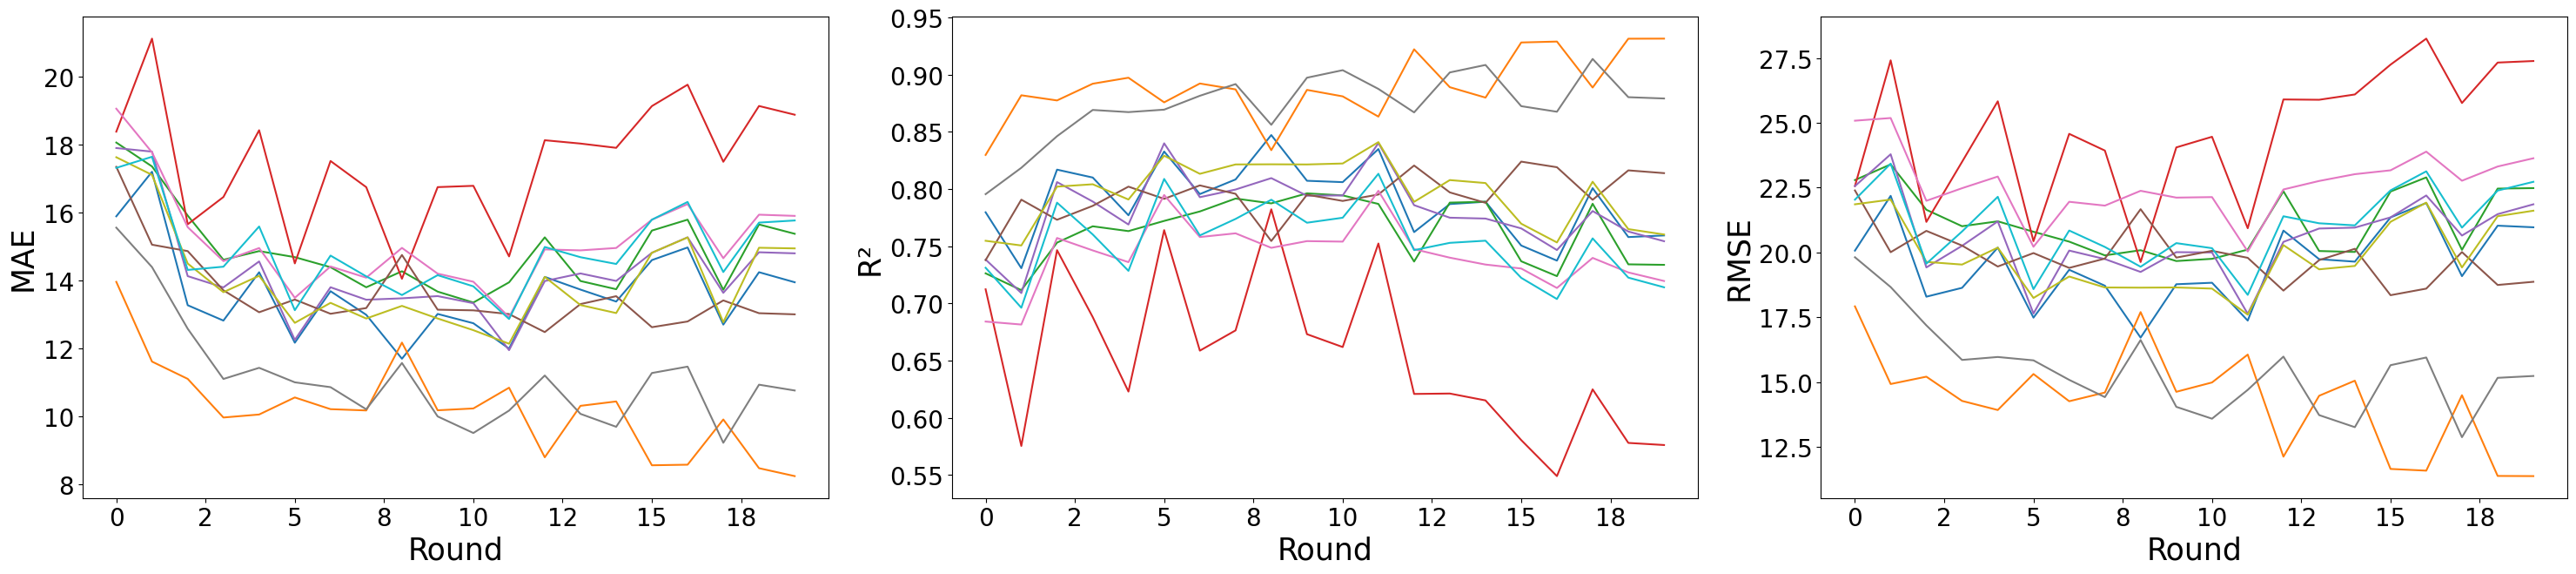

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae_4[global_stats_mae_4.columns[1:11]], label='train')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R² instead of MAP
ax2.plot(global_stats_r2_4[global_stats_r2_4.columns[1:11]], label='train')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse_4[global_stats_rmse_4.columns[1:11]], label='train')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.tight_layout()
plt.show()
#pyplot.savefig(f'federated-KRUM_{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

In [ ]:
print('size of model: ', sys.getsizeof(global_model.get_weights()))

size of model:  184


### Calculating the average metrics across all rounds and storing them in new columns

In [ ]:
global_stats_mae_4['A'] = (global_stats_mae_4['0'] + global_stats_mae_4['1'] + global_stats_mae_4['2'] + global_stats_mae_4['3'] +
                         global_stats_mae_4['4'] + global_stats_mae_4['5'] + global_stats_mae_4['6'] + global_stats_mae_4['7'] +
                         global_stats_mae_4['8'] + global_stats_mae_4['9'] + global_stats_mae_4['test']) / 11

global_stats_r2_4['A'] = (global_stats_r2_4['0'] + global_stats_r2_4['1'] + global_stats_r2_4['2'] + global_stats_r2_4['3'] +
                          global_stats_r2_4['4'] + global_stats_r2_4['5'] + global_stats_r2_4['6'] + global_stats_r2_4['7'] +
                          global_stats_r2_4['8'] + global_stats_r2_4['9'] + global_stats_r2_4['test']) / 11

global_stats_rmse_4['A'] = (global_stats_rmse_4['0'] + global_stats_rmse_4['1'] + global_stats_rmse_4['2'] + global_stats_rmse_4['3'] +
                          global_stats_rmse_4['4'] + global_stats_rmse_4['5'] + global_stats_rmse_4['6'] + global_stats_rmse_4['7'] +
                          global_stats_rmse_4['8'] + global_stats_rmse_4['9'] + global_stats_rmse_4['test']) / 11

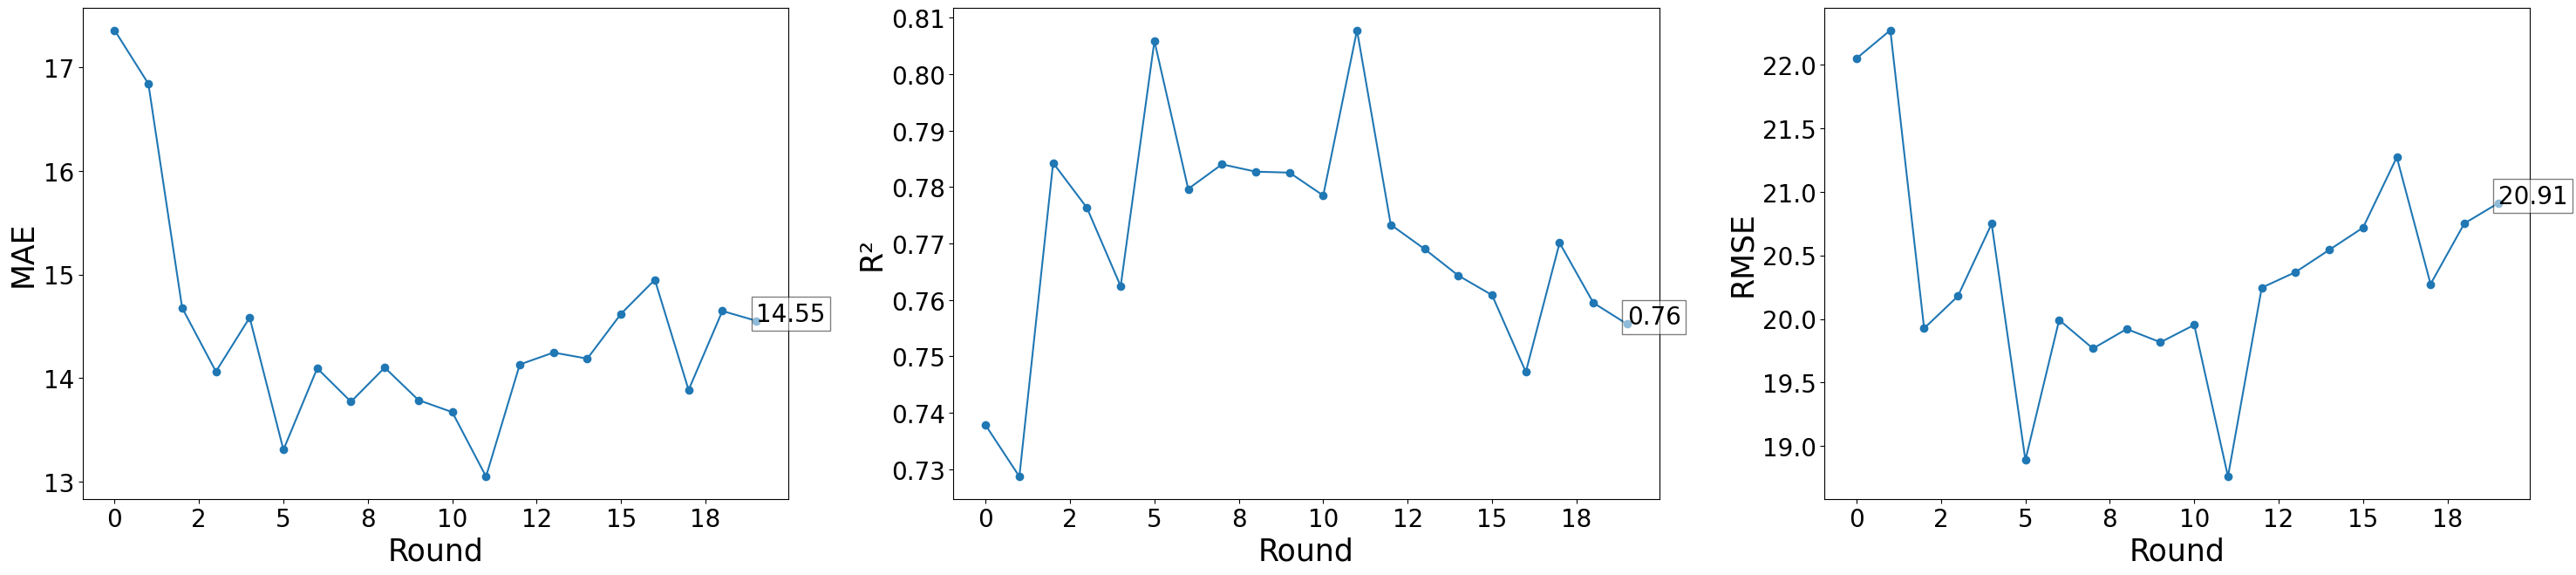

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae_4['A'], label='train', marker='o')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R²
ax2.plot(global_stats_r2_4['A'], label='train', marker='o')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse_4['A'], label='train', marker='o')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add text annotations for the last round values
round_idx = len(global_stats_mae_4) - 1
ax1.text(round_idx, global_stats_mae_4['A'][round_idx], f'{global_stats_mae_4["A"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax2.text(round_idx, global_stats_r2_4['A'][round_idx], f'{global_stats_r2_4["A"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax3.text(round_idx, global_stats_rmse_4['A'][round_idx], f'{global_stats_rmse_4["A"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.tight_layout()
plt.show()

pyplot.savefig(f'global-KRUM_{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

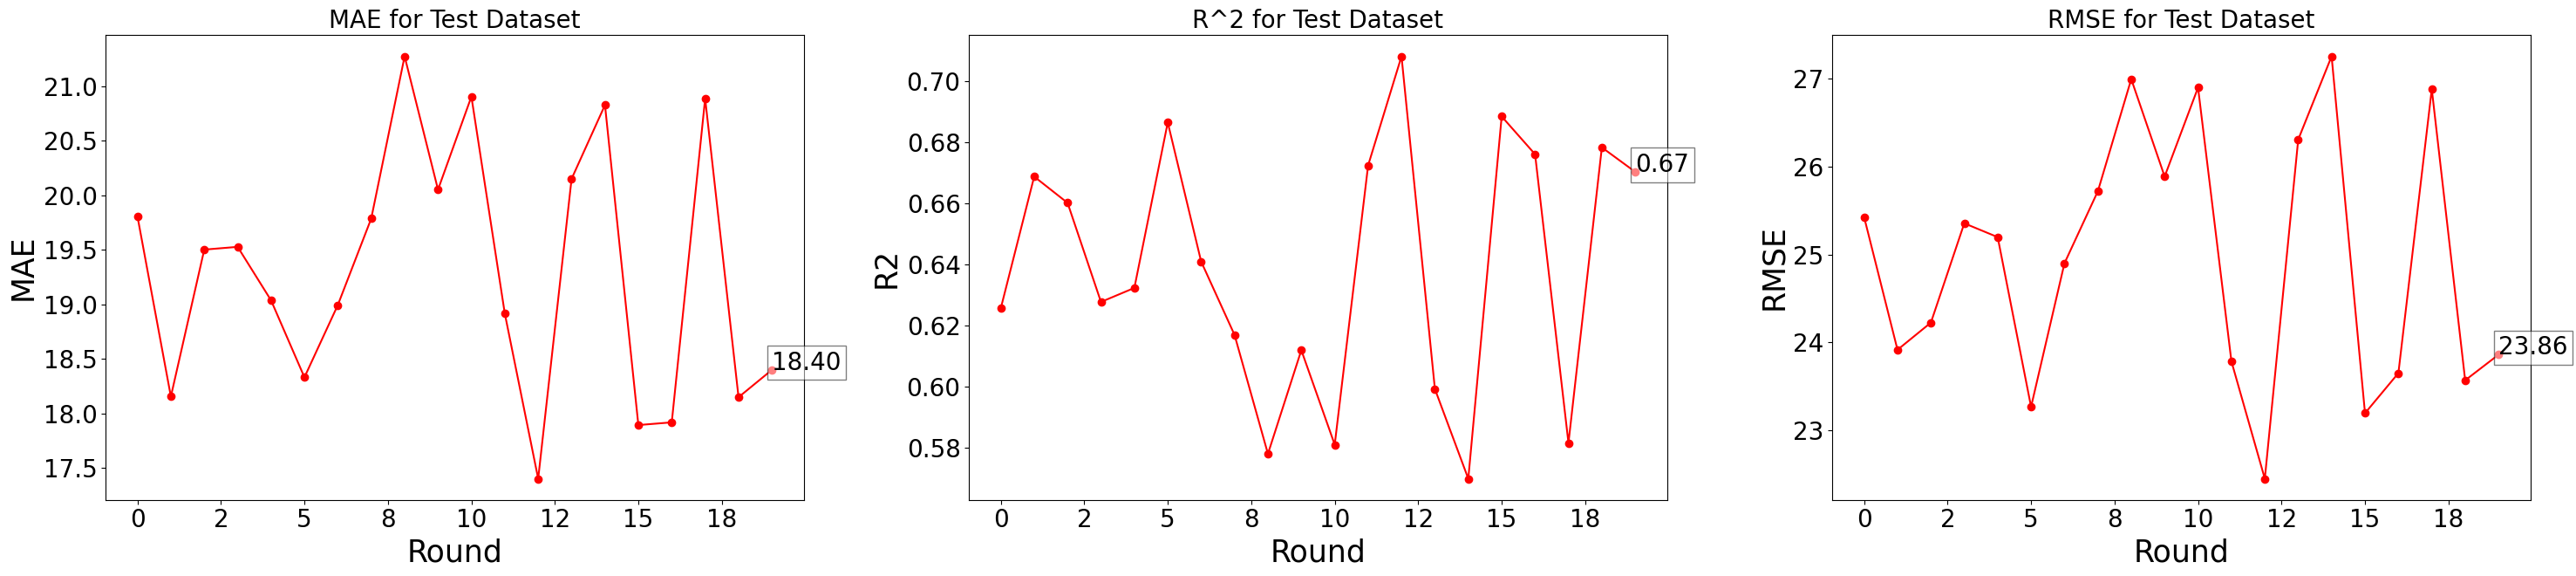

In [ ]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

ax1.plot(global_stats_mae_4['test'], label='test', marker='o', color='red')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax2.plot(global_stats_r2_4['test'], label='test', marker='o', color='red')
ax2.set_ylabel('R2', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax3.plot(global_stats_rmse_4['test'], label='test', marker='o', color='red')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

round_idx = len(global_stats_mae_4) - 1  
ax1.text(round_idx, global_stats_mae_4['test'][round_idx], f'{global_stats_mae_4["test"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax2.text(round_idx, global_stats_r2_4['test'][round_idx], f'{global_stats_r2_4["test"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax3.text(round_idx, global_stats_rmse_4['test'][round_idx], f'{global_stats_rmse_4["test"][round_idx]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

ax1.set_title('MAE for Test Dataset', fontsize=20)
ax2.set_title('R^2 for Test Dataset', fontsize=20)
ax3.set_title('RMSE for Test Dataset', fontsize=20)

plt.tight_layout()

plt.show()

In [ ]:
global_stats_mae_4.to_csv('global_stats_mae_KRUM.csv', index=False)
global_stats_r2_4.to_csv('global_stats_r2_KRUM.csv', index=False)
global_stats_rmse_4.to_csv('global_stats_rmse_KRUM.csv', index=False)